# Initializing the Modules

In [1]:
import os
import numpy as np
import operator

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Collecting a Dataset


1. You will use a dataset from the CoNLL conferences that benchmark natural language processing systems and tasks. There were two conferences on named entity recognition: CoNLL 2002 (Spanish and Dutch) and CoNLL 2003 (English and German). In this assignment, you will work on the English dataset. Read the description of the task.

2. The datasets are protected by a license and you need to obtain it to reconstruct the data. Alternatively, you can use a local copy or try to find one on github (type conll2003 in the search box) or use the Google dataset search: https://toolbox.google.com/datasetsearch. You can find a local copy in the /usr/local/cs/EDAN95/datasets/NER-data folder.

3. The dataset comes in the form of three files: a training set, a development set, and a test set. You will use the test set to evaluate your models. For this, you will apply the conlleval script that will compute the harmonic mean of the precision and recall: F1. You have a local copy of this script in /usr/local/cs/EDAN95/datasets/ner/bin. conlleval is written in Perl. Be sure to have it on your machine to run it.

# Collecting the Embeddings

1. Download the GloVe embeddings 6B from https://nlp.stanford.edu/projects/glove/ and keep the 100d vectors.

2. Write a function that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embeddings.

In [2]:
glove_dir = '/Users/Marcel/Documents/Python/edan95/project_4/glove.6b'
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


3. Using a cosine similarity, compute the 5 closest words to the words table, france, and sweden.

In [6]:
def cos_sim(v1, v2):
    """Measures the cosine similiarity between two vectors
    """
    den = np.dot(v1, v2)
    num = np.linalg.norm(v1)*np.linalg.norm(v2)
    return den/num


def find_closest_words(dictonary, word, n):
    word_list = [(cos_sim(dictonary[word], value), key) for key, value in embeddings_index.items()]
    sorted_list = sorted(word_list, key=lambda tup: tup[0], reverse=True)
    return sorted_list[0:n-1]

closest_2_france = find_closest_words(embeddings_index, 'france', 7)
print(closest_2_france[1:])

closest_2_sweden = find_closest_words(embeddings_index, 'sweden', 7)
print(closest_2_sweden[1:])

closest_2_table = find_closest_words(embeddings_index, 'table', 7)
print(closest_2_table[1:])

[(0.8076423, 'belgium'), (0.8004377, 'french'), (0.79505277, 'britain'), (0.7557464, 'spain'), (0.74815863, 'paris')]
[(0.8624401, 'denmark'), (0.80732495, 'norway'), (0.7906495, 'finland'), (0.74684644, 'netherlands'), (0.74668366, 'austria')]
[(0.80211616, 'tables'), (0.6582379, 'place'), (0.65597206, 'bottom'), (0.65436906, 'room'), (0.6433667, 'side')]


# Reading the Corpus and Building Indices
You will read the corpus with programs available from https://github.com/pnugues/edan95. These programs will enable you to load the files in the form of a list of dictionaries.

1. Write a function that for each sentence returns the X and Y lists of symbols consisting of words and NER tags.

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras import Input
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [9]:
BASE_DIR = '/Users/Marcel/Documents/Python/edan95/project_4/conll003-englishversion/'

# Reading the corpus
def load_conll2003_en():
    train_file = BASE_DIR + 'train.txt'
    dev_file = BASE_DIR + 'valid.txt'
    test_file = BASE_DIR + 'test.txt'
    column_names = ['form', 'ppos', 'pchunk', 'ner']
    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

# The dictorizer that transforms the CoNLL files into dictionaries¶
import regex as re

class Token(dict):
    pass

class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]
    
train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()

conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
print(train_dict[0])
print(train_dict[1])

# Building the sequences¶

## The function to build the sequences
def build_sequences(corpus_dict, key_x='form', key_y='pos', tolower=True):
    """
    Creates sequences from a list of dictionaries
    :param corpus_dict:
    :param key_x:
    :param key_y:
    :return:
    """
    X = []
    Y = []
    for sentence in corpus_dict:
        x = [word[key_x] for word in sentence]
        y = [word[key_y] for word in sentence]
        if tolower:
            x = list(map(str.lower, x))
        X += [x]
        Y += [y]
    return X, Y

## Train dataset

# We build the words and NER sequence tags¶
X_words, Y_ner = build_sequences(train_dict, key_x='form', key_y='ner')
print('First sentence, words', X_words[1])
print('First sentence, NER', Y_ner[1])


# We now extract the list of unique words and NER
word_set = sorted(list(set([item for sublist in X_words for item in sublist])))
ner_set = sorted(list(set([item for sublist in Y_ner for item in sublist])))
print(len(word_set))
print(len(ner_set))
ner_set


## Same but for dev dataset
X_words_dev, Y_ner_dev = build_sequences(dev_dict, key_x='form', key_y='ner')

# Extract the list of unique words and NER and vocab including glove 
word_set_dev = sorted(list(set([item for sublist in X_words_dev for item in sublist])))
ner_set_dev = sorted(list(set([item for sublist in Y_ner_dev for item in sublist])))

[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': '-X-', 'ner': 'O'}]
[{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'B-NP', 'ner': 'B-ORG'}, {'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'B-VP', 'ner': 'O'}, {'form': 'German', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}, {'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': 'to', 'ppos': 'TO', 'pchunk': 'B-VP', 'ner': 'O'}, {'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}, {'form': 'British', 'ppos': 'JJ', 'pchunk': 'B-NP', 'ner': 'B-MISC'}, {'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}, {'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}]
First sentence, words ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
First sentence, NER ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
21010
9


2. Create a vocabulary of all the words observed in the training set and the words in GloVe.

In [10]:
glove_set = sorted([key for key in embeddings_index.keys() if key.isalpha()])
print(glove_set[0:20])

glove_set.extend(word_set)
#vocab = sorted(list(set(glove_set + word_set)))

#print(len(vocab))
voc = set(glove_set)

['a', 'aa', 'aaa', 'aaaa', 'aaaaa', 'aaah', 'aaahh', 'aaai', 'aaas', 'aab', 'aaba', 'aabar', 'aabb', 'aabel', 'aabenraa', 'aaberg', 'aac', 'aacc', 'aach', 'aachen']


3. Create indices and inverted indices for the words and the NER: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words.

In [11]:
## Train dataset
rev_word_idx = dict(enumerate(word_set, start=2))
rev_ner_idx = dict(enumerate(ner_set, start=2))
word_idx = {v: k for k, v in rev_word_idx.items()}
ner_idx = {v: k for k, v in rev_ner_idx.items()}

rev_word_idx[0] = 0
rev_word_idx[1] = 1

print(rev_ner_idx)
print(ner_idx)

## Dev dataset
rev_word_idx_dev = dict(enumerate(voc, start=2))
rev_ner_idx_dev = dict(enumerate(ner_set_dev, start=2))
rev_word_idx_dev[0]=0
rev_word_idx_dev[1]=1
word_idx_dev = {v: k for k, v in rev_word_idx_dev.items()}
ner_idx_dev = {v: k for k, v in rev_ner_idx_dev.items()}

{2: 'B-LOC', 3: 'B-MISC', 4: 'B-ORG', 5: 'B-PER', 6: 'I-LOC', 7: 'I-MISC', 8: 'I-ORG', 9: 'I-PER', 10: 'O'}
{'B-LOC': 2, 'B-MISC': 3, 'B-ORG': 4, 'B-PER': 5, 'I-LOC': 6, 'I-MISC': 7, 'I-ORG': 8, 'I-PER': 9, 'O': 10}


In [12]:
word_idx

{'!': 2,
 '"': 3,
 '$': 4,
 '%': 5,
 '&': 6,
 "'": 7,
 "'d": 8,
 "'ll": 9,
 "'m": 10,
 "'re": 11,
 "'s": 12,
 "'ve": 13,
 '(': 14,
 ')': 15,
 '*': 16,
 '**': 17,
 '**general': 18,
 '*indices': 19,
 '*name': 20,
 '*note': 21,
 '+': 22,
 '++359-2': 23,
 '+0,2': 24,
 '+0.0': 25,
 '+0.05': 26,
 '+0.1': 27,
 '+0.2': 28,
 '+0.4m': 29,
 '+0.7': 30,
 '+0.9;+23.6': 31,
 '+1': 32,
 '+1,161': 33,
 '+1.0': 34,
 '+1.2': 35,
 '+1.5': 36,
 '+1.7;+22.0': 37,
 '+1.9': 38,
 '+10.8': 39,
 '+11': 40,
 '+12': 41,
 '+12,696': 42,
 '+15,272': 43,
 '+16': 44,
 '+16.4': 45,
 '+167,330': 46,
 '+168,130': 47,
 '+17': 48,
 '+18.3': 49,
 '+19': 50,
 '+2': 51,
 '+2.3r': 52,
 '+2.6': 53,
 '+20': 54,
 '+22': 55,
 '+225': 56,
 '+230.4': 57,
 '+25': 58,
 '+27': 59,
 '+282.1': 60,
 '+3': 61,
 '+3,428': 62,
 '+3,831': 63,
 '+3.06': 64,
 '+3.4': 65,
 '+3.5': 66,
 '+3.6': 67,
 '+3.7': 68,
 '+301': 69,
 '+31': 70,
 '+31,230': 71,
 '+310.4': 72,
 '+33': 73,
 '+331': 74,
 '+34': 75,
 '+353': 76,
 '+358': 77,
 '+361': 78,
 '+3

# Building the Embedding Matrix


1. Create a matrix of dimensions (M, N), where M will the size of the vocabulary: The unique words in the training set and the words in GloVe, and N, the dimension of the embeddings. Initialize it with random values.

In [13]:

print(len(glove_set))

#glove_set.extend(word_set)
#vocab = sorted(list(set(glove_set + word_set)))

#print(len(vocab))
#voc = set(glove_set)

rev_voc_idx = dict(enumerate(voc, start=2))
voc_idx = {v: k for k, v in rev_voc_idx.items()}

print(len(voc))

M = len(voc) + 2 # max_words
N = len(embeddings_index['france']) # embedding_dim
#N = len(ner_set)

embedding_matrix = np.random.rand(M,N)
print(M)
print(N)

348101
332834
332836
100


2. Fill the matrix with the GloVe embeddings. You will use the indices from the previous section.

In [12]:
for word, i in voc_idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Creating the X and Y Sequences

1. Convert the X and Y list of symbols in a list of numbers using the indices you created.


Before: We have the symbols

In [13]:
print('First sentence, words', X_words[1])
print('First sentence, NER', Y_ner[1])

First sentence, words ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
First sentence, NER ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


We want to create sequences of numbers, let us convert them!

In [14]:
X_words_idx = [list(map(lambda x: word_idx.get(x, 1), x)) for x in X_words]
Y_ner_idx = [list(map(lambda x: ner_idx.get(x, 1), x)) for x in Y_ner]

In [15]:
print('First sentence, words', X_words_idx[1])
print('First sentence, NER', Y_ner_idx[1])

First sentence, words [8780, 16385, 9880, 5996, 19360, 5682, 5783, 12212, 125]
First sentence, NER [4, 10, 3, 10, 10, 10, 3, 10, 10]


2. Pad the sentences using the pad_sequences function.


We do this because all the sentences needs to have the same length

In [16]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 150
X_words_idx = pad_sequences(X_words_idx,maxlen=maxlen)
Y_ner_idx = pad_sequences(Y_ner_idx,maxlen=maxlen)

In [17]:
print('First sentence, words', X_words_idx[1])
print('First sentence, NER', Y_ner_idx[1])

First sentence, words [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0  8780 16385  9880
  5996 19360  5682  5783 12212   125]
First sentence, NER [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  

Let's do the same for validation set

3. Do the same for the development set.


In [18]:
X_words_idx_dev = [list(map(lambda x: word_idx_dev.get(x, 1), x)) for x in X_words_dev]
Y_ner_idx_dev = [list(map(lambda x: ner_idx_dev.get(x, 1), x)) for x in Y_ner_dev]
X_words_idx_dev = pad_sequences(X_words_idx_dev,maxlen=maxlen)
Y_ner_idx_dev = pad_sequences(Y_ner_idx_dev,maxlen=maxlen)

In [19]:
from keras.utils.np_utils import to_categorical
Y_ner_idx_cat = to_categorical(Y_ner_idx)
Y_ner_idx_dev_cat = to_categorical(Y_ner_idx_dev)


# Building a Simple Recurrent Neural Network


1. Create a simple recurrent network and train a model with the train set. As layers, you will use Embedding, SimpleRNN, and Dense.


In [20]:
ner_vocab_size=len(ner_idx.keys())+2
print(ner_vocab_size)

11


In [21]:
text_vocabulary_size = len(voc) + 2
print('text_vocabulary_size\t',text_vocabulary_size)
print('embedding_dim\t\t',N)
print('maxlen\t\t\t',maxlen)
print('ner_vocab_size\t\t',ner_vocab_size)
print('X\t\t\t',X_words_idx.shape)
print('Y\t\t\t',Y_ner_idx.shape)
print('X_val\t\t\t',X_words_idx_dev.shape)
print('Y_val\t\t\t',Y_ner_idx_dev.shape)

text_vocabulary_size	 332836
embedding_dim		 100
maxlen			 150
ner_vocab_size		 11
X			 (14987, 150)
Y			 (14987, 150)
X_val			 (3466, 150)
Y_val			 (3466, 150)


In [22]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN,Bidirectional

model = Sequential() 

# input här kommer vara emb_mat som vi lägger till som vikter i emb_lay och fryser så att de inte kan förändras
model.add(Embedding(text_vocabulary_size, N,input_length=maxlen,mask_zero=False))
model.layers[0].set_weights([embedding_matrix]) 
model.layers[0].trainable = False # Det är här vi fryser
# output blir 150 x 100

model.add(Bidirectional(SimpleRNN(32,return_sequences=True)))
model.add(Dense(ner_vocab_size, activation='softmax')) 

model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          33283600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 64)           8512      
_________________________________________________________________
dense_1 (Dense)              (None, 150, 11)           715       
Total params: 33,292,827
Trainable params: 9,227
Non-trainable params: 33,283,600
_________________________________________________________________


2. Compile and fit your network. You will report the training and validation losses and accuracies and comment on the possible overfit.


In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc']) 

In [31]:
history = model.fit(X_words_idx, Y_ner_idx_cat,
          epochs=3, 
          batch_size=128,
          validation_data=(X_words_idx_dev, Y_ner_idx_dev_cat))

Train on 14987 samples, validate on 3466 samples
Epoch 1/3
14987/14987 [==============================] - 41s 3ms/step - loss: 0.0499 - acc: 0.9875 - val_loss: 0.2512 - val_acc: 0.9341
Epoch 2/3
14987/14987 [==============================] - 40s 3ms/step - loss: 0.0476 - acc: 0.9878 - val_loss: 0.2116 - val_acc: 0.9434
Epoch 3/3
14987/14987 [==============================] - 41s 3ms/step - loss: 0.0459 - acc: 0.9881 - val_loss: 0.1842 - val_acc: 0.9530


Plotting the results

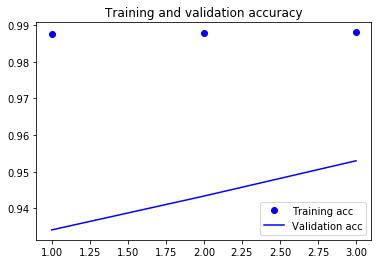

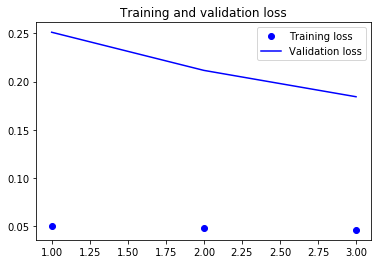

In [34]:
import matplotlib.pyplot as plt

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

3. Apply your network to the test set and report the accuracy you obtained. You will use the evaluate method.


# Evaluating your System
You will use the official script to evaluate the performance of your system



1. Use the predict method to predict the tags of the whole test set


2. Write your results in a file, where the two last columns will be the hand-annotated tag and the predicted tag. The fields must be separated by a space.


3. Apply conlleval to your output. Report the F1 result.


4. Try to improve your model by modifying some parameters, adding layers, adding Bidirectional and Dropout.


5. Evaluate your network again


Preprocessing

In [26]:
test_dict = conll_dict.transform(test_sentences)
X_words, Y_ner = build_sequences(test_dict, key_x='form', key_y='ner')
X_words_test, Y_ner_test = build_sequences(test_dict, key_x='form', key_y='ner')

# Extract the list of unique words and NER and vocab including glove 
word_set_test = sorted(list(set([item for sublist in X_words_test for item in sublist])))
ner_set_test = sorted(list(set([item for sublist in Y_ner_test for item in sublist])))

# Building the indices 
rev_word_idx_test = dict(enumerate(voc, start=2))
rev_ner_idx_test = dict(enumerate(ner_set_test, start=2))
rev_word_idx_test[0]=0
rev_word_idx_test[1]='-unknown-'
word_idx_test = {v: k for k, v in rev_word_idx_test.items()}
ner_idx_test = {v: k for k, v in rev_ner_idx_test.items()}

# Converting sequences to indicies
X_words_idx_test = [list(map(lambda x: word_idx_test.get(x, 1), x)) for x in X_words_test]
X_words_idx_test = pad_sequences(X_words_idx_test,maxlen=maxlen)

In [27]:
predicted = model.predict(X_words_idx_test)

In [28]:
def creat_output(predicted, ner_idx,X_words_test,Y_ner_test,filename):
    Y_out_pad= np.argmax(predicted,axis=2)
    inv_ner_idx = {v: k for k, v in ner_idx.items()}
    Y_out = []
    inv_ner_idx[0]='O'
    inv_ner_idx[1]='wtf'
    for i in range(len(Y_out_pad)):
        temp_old = Y_out_pad[i][-(len(X_words_test[i])):]
        temp_new = []
        for j in temp_old:
            temp_new.append(inv_ner_idx[j])
        Y_out.append(temp_new)

    f_out = open(filename, 'w')
    for i in range(len(X_words_test)): # For each sentence
        for j in range(len(X_words_test[i])): # Fore each word
            word = X_words_test[i][j]
            NER = Y_ner_test[i][j]
            PNER = Y_out[i][j]
            f_out.write(word + ' ' + NER + ' ' + PNER + '\n')
        f_out.write('\n')
    f_out.close()
    return Y_out


In [39]:
Y_new = creat_output(predicted, ner_idx,X_words_test,Y_ner_test,'new_out')
!perl ./conlleval.pl <new_out

processed 46666 tokens with 5648 phrases; found: 723 phrases; correct: 13.
accuracy:  77.61%; precision:   1.80%; recall:   0.23%; FB1:   0.41
                 : precision:   0.00%; recall:   0.00%; FB1:   0.00  43
              LOC: precision:   6.12%; recall:   0.18%; FB1:   0.35  49
             MISC: precision:   5.88%; recall:   0.28%; FB1:   0.54  34
              ORG: precision:   4.31%; recall:   0.30%; FB1:   0.56  116
              PER: precision:   0.62%; recall:   0.19%; FB1:   0.29  481


# Building a LSTM Network


1. Create a simple LSTM network and train a model with the train set. As layers, you will use Embedding, LSTM, and Dense.


2. Apply conlleval to your output. Report the F1 result.


3. Try to improve your model by modifying some parameters, adding layers, adding Bidirectional, Dropout, possibly mixing SimpleRNN.


4. Apply your network to the test set and report the accuracy you obtained. you need to reach a F1 of 82 to pass.


In [41]:
from keras.layers import LSTM, Dropout

model = Sequential() 

# input här kommer vara emb_mat som vi lägger till som vikter i emb_lay och fryser så att de inte kan förändras
model.add(Embedding(text_vocabulary_size,N,input_length=maxlen,mask_zero=False))
# output blir 150 x 100

model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Bidirectional(SimpleRNN(100,return_sequences=True)))
model.add(Dense(200, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(ner_vocab_size, activation='softmax')) 

model.layers[0].set_weights([embedding_matrix]) 
model.layers[0].trainable = False

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 100)          33283600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 200)          160800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 150, 200)          60200     
_________________________________________________________________
dense_2 (Dense)              (None, 150, 200)          40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 150, 11)           2211      
Total params: 33,547,011
Tr

In [42]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc']) 
model.fit(X_words_idx, Y_ner_idx_cat,
          epochs=3, 
          batch_size=128,
          validation_data=(X_words_idx_dev, Y_ner_idx_dev_cat))

Train on 14987 samples, validate on 3466 samples
Epoch 1/10
14987/14987 [==============================] - 379s 25ms/step - loss: 0.1182 - acc: 0.9730 - val_loss: 0.3262 - val_acc: 0.9179
Epoch 2/10
14987/14987 [==============================] - 310s 21ms/step - loss: 0.0570 - acc: 0.9868 - val_loss: 0.3145 - val_acc: 0.9227
Epoch 3/10
14987/14987 [==============================] - 328s 22ms/step - loss: 0.0471 - acc: 0.9878 - val_loss: 0.2504 - val_acc: 0.9264
Epoch 4/10
14987/14987 [==============================] - 433s 29ms/step - loss: 0.0407 - acc: 0.9888 - val_loss: 0.2397 - val_acc: 0.9269
Epoch 5/10
14987/14987 [==============================] - 371s 25ms/step - loss: 0.0356 - acc: 0.9899 - val_loss: 0.2926 - val_acc: 0.9195
Epoch 6/10
14987/14987 [==============================] - 353s 24ms/step - loss: 0.0319 - acc: 0.9908 - val_loss: 0.2081 - val_acc: 0.9388
Epoch 7/10
14987/14987 [==============================] - 316s 21ms/step - loss: 0.0287 - acc: 0.9915 - val_loss: 0.1

In [43]:
predicted = model.predict(X_words_idx_test)

In [44]:
Y_new = creat_output(predicted, ner_idx,X_words_test,Y_ner_test,'BILSTM100_BISRNN100_200_DO_8ep_out')

In [45]:
!perl ./conlleval.pl <BILSTM100_BISRNN100_200_DO_8ep_out

processed 46666 tokens with 5648 phrases; found: 13558 phrases; correct: 87.
accuracy:  49.69%; precision:   0.64%; recall:   1.54%; FB1:   0.91
              LOC: precision:   5.44%; recall:   2.04%; FB1:   2.97  625
             MISC: precision:   0.42%; recall:   2.42%; FB1:   0.71  4058
              ORG: precision:   0.51%; recall:   0.90%; FB1:   0.65  2930
              PER: precision:   0.35%; recall:   1.30%; FB1:   0.56  5945
